In [1]:
import pandas as pd 
import numpy as np 
import os 
import pickle
import tqdm
from konlpy.tag import Mecab
from transformers import *
import torch
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from kss import split_sentences
import re
import numpy as np 
import pandas as pd 
from transformers import * 
import torch
import torch.nn as nn 
import torch.functional as F 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold 
import random 
import time 
import datetime 
from tqdm import tqdm 
import gc
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import seaborn as sns
from kss import split_sentences
import yfinance
from pandas_datareader import data

## Get Scraped News Data

In [2]:
scraped_news = pd.read_csv('005930_news_scraped.csv') 

In [3]:
scraped_news.head()

,Unnamed: 0,날짜,언론사,기사제목,링크
0,0,2021.03.25 16:02,이데일리,"온라인 마케팅 강화나서자 삼성 ""회원 40%↑""…LG ""매출 비중 15...",https://finance.naver.com/item/news_read.nhn?a...
1,1,2021.03.25 15:42,서울경제,"삼성전자, 초고화질 영화 2편 1초에 전송하는 반도체 개발",https://finance.naver.com/item/news_read.nhn?a...
2,2,2021.03.25 11:52,헤럴드경제,1초에 UHD 영화 2편 내려 받는다...삼성 DDR5 개발 성공,https://finance.naver.com/item/news_read.nhn?a...
3,3,2021.03.25 11:23,아시아경제,"""차세대 시장 선도"" …삼성, 인텔과 고성능 D램 협력 강화",https://finance.naver.com/item/news_read.nhn?a...
4,4,2021.03.25 11:07,서울경제,"삼성, 세계 최초 혁신공정 적용한 차세대 DDR5 선보여···고성능·...",https://finance.naver.com/item/news_read.nhn?a...


In [4]:
scraped_news['날짜'] = scraped_news['날짜'].apply(lambda x : x[:-6]) 
scraped_news['날짜'] = scraped_news['날짜'].apply(lambda x : x.strip(' '))

In [5]:
scraped_news.head()

,Unnamed: 0,날짜,언론사,기사제목,링크
0,0,2021.03.25,이데일리,"온라인 마케팅 강화나서자 삼성 ""회원 40%↑""…LG ""매출 비중 15...",https://finance.naver.com/item/news_read.nhn?a...
1,1,2021.03.25,서울경제,"삼성전자, 초고화질 영화 2편 1초에 전송하는 반도체 개발",https://finance.naver.com/item/news_read.nhn?a...
2,2,2021.03.25,헤럴드경제,1초에 UHD 영화 2편 내려 받는다...삼성 DDR5 개발 성공,https://finance.naver.com/item/news_read.nhn?a...
3,3,2021.03.25,아시아경제,"""차세대 시장 선도"" …삼성, 인텔과 고성능 D램 협력 강화",https://finance.naver.com/item/news_read.nhn?a...
4,4,2021.03.25,서울경제,"삼성, 세계 최초 혁신공정 적용한 차세대 DDR5 선보여···고성능·...",https://finance.naver.com/item/news_read.nhn?a...


## Get Samsung Chart Data

In [6]:
#chart_data = data.get_data_yahoo('035720.ks', '2016-01-01', '2021-03-25')
#kakao_close = chart_data['Close'].values 
#plt.plot(kakao_close)

In [7]:
chart_data = data.get_data_yahoo('005930.ks', '2020-12-01', '2021-03-26')

In [8]:
chart_data['Date'] = chart_data.index

In [9]:
close_prices = chart_data['Close'].values

In [10]:
chart_dates_raw = chart_data['Date'].values 

In [11]:
chart_dates = []  
for date in chart_dates_raw: 
    chart_dates.append(str(date).replace("T00:00:00.000000000","").replace("-","."))

In [12]:
close_price_dict = {} 
for i in range(len(chart_dates)): 
    close_price_dict[chart_dates[i]] = close_prices[i] 

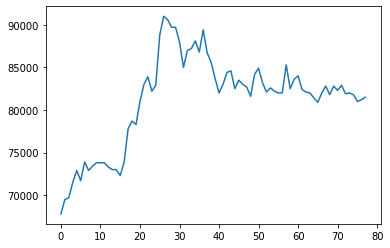

In [13]:
plt.plot(close_prices)

In [14]:
sentiments = [] 
for i in range(0, len(close_prices)-1):  
    
    if close_prices[i] <= close_prices[i+1]:  
        sentiments.append(1)
    else: 
        sentiments.append(0)
        
sentiments = np.asarray(sentiments)

## Label samsung financial news titles 

In [15]:
#assign labels by dates 
dates = scraped_news['날짜']  
titles = scraped_news['기사제목'] 

table = {} 
for i in range(len(dates)): 
    table[dates[i]] = []  
    
for i in range(len(dates)):  
    table[dates[i]].append(titles[i]) 

In [16]:
## table consists of the dates for when the news is released 
## if the close price next day is greater than the close price today, then we label the news today as 1 (+ve sentiment)
## else we label it as 0 (+ve sentiment) 

labels = [] 
cur_date = '' 
for key in sorted(table.keys()):   
    info = key.split('.')  
    year = int(info[0]) 
    month = int(info[1]) 
    day = int(info[2])  
    date = key.strip()    
    if date in chart_dates: 
        cur_date = date  
    while True: 
        if day >= 25 and month == 3: 
            break 
        
        day += 1 
        if month == 12 and day > 31:  
            month = 1 
            day = 1 
            year = 2021
        elif month == 1 and day > 31: 
            month = 2
            day = 1 
        elif month == 2 and day > 28: 
            month = 3 
            day = 1  
            
            
        if month < 10:  
            str_month = '0' + str(month) 
        else: 
            str_month = str(month) 
            
        if day < 10:  
            str_day = '0' + str(day)  
        else: 
            str_day = str(day)
        
        date = str(year) + '.' + str_month + '.' + str_day
        
        if date in chart_dates: 
            break 
        
    
    next_date = date 
    
    if close_price_dict[cur_date] <= close_price_dict[next_date]: 
        labels.append(1) 
    else: 
        labels.append(0) 
        

labels = np.asarray(labels)
    

In [17]:
label_dict = {} 
idx = 0 
for key in sorted(table.keys()): 
    label_dict[key.strip()] = labels[idx] 
    idx += 1 

In [18]:
df_labels = [] 
news_dates = scraped_news['날짜'].values 


for date in news_dates: 
    df_labels.append(label_dict[date]) 
    

In [19]:
scraped_news['sentiment'] = df_labels 

scraped_news.head()

,Unnamed: 0,날짜,언론사,기사제목,링크,sentiment
0,0,2021.03.25,이데일리,"온라인 마케팅 강화나서자 삼성 ""회원 40%↑""…LG ""매출 비중 15...",https://finance.naver.com/item/news_read.nhn?a...,1
1,1,2021.03.25,서울경제,"삼성전자, 초고화질 영화 2편 1초에 전송하는 반도체 개발",https://finance.naver.com/item/news_read.nhn?a...,1
2,2,2021.03.25,헤럴드경제,1초에 UHD 영화 2편 내려 받는다...삼성 DDR5 개발 성공,https://finance.naver.com/item/news_read.nhn?a...,1
3,3,2021.03.25,아시아경제,"""차세대 시장 선도"" …삼성, 인텔과 고성능 D램 협력 강화",https://finance.naver.com/item/news_read.nhn?a...,1
4,4,2021.03.25,서울경제,"삼성, 세계 최초 혁신공정 적용한 차세대 DDR5 선보여···고성능·...",https://finance.naver.com/item/news_read.nhn?a...,1


In [20]:
scraped_news.to_csv('005930_news_scraped_labeled.csv') 

In [21]:
## positive sentiment 
scraped_news[scraped_news['sentiment']==1]

,Unnamed: 0,날짜,언론사,기사제목,링크,sentiment
0,0,2021.03.25,이데일리,"온라인 마케팅 강화나서자 삼성 ""회원 40%↑""…LG ""매출 비중 15...",https://finance.naver.com/item/news_read.nhn?a...,1
1,1,2021.03.25,서울경제,"삼성전자, 초고화질 영화 2편 1초에 전송하는 반도체 개발",https://finance.naver.com/item/news_read.nhn?a...,1
2,2,2021.03.25,헤럴드경제,1초에 UHD 영화 2편 내려 받는다...삼성 DDR5 개발 성공,https://finance.naver.com/item/news_read.nhn?a...,1
3,3,2021.03.25,아시아경제,"""차세대 시장 선도"" …삼성, 인텔과 고성능 D램 협력 강화",https://finance.naver.com/item/news_read.nhn?a...,1
4,4,2021.03.25,서울경제,"삼성, 세계 최초 혁신공정 적용한 차세대 DDR5 선보여···고성능·...",https://finance.naver.com/item/news_read.nhn?a...,1
...,...,...,...,...,...,...
17802,17802,2020.12.01,머니투데이,삼성전자·SK하이닉스 덕분에…3분기 2%대 성장률 달성,https://finance.naver.com/item/news_read.nhn?a...,1
17803,17803,2020.12.01,한국경제,애플·삼성 아니네?…'지속가능 100대 기업' 1위 어디길래,https://finance.naver.com/item/news_read.nhn?a...,1
17804,17804,2020.12.01,한국경제,'7만 전자' 밀고가는 개미들…삼성전자 1.2조 쓸어담았다 [이슈+],https://finance.naver.com/item/news_read.nhn?a...,1
17805,17805,2020.12.01,헤럴드경제,애플 제친 샤오미…3분기 스마트폰 시장 1위는 ‘삼성’,https://finance.naver.com/item/news_read.nhn?a...,1


In [22]:
scraped_news[scraped_news['sentiment']==0]

,Unnamed: 0,날짜,언론사,기사제목,링크,sentiment
68,68,2021.03.23,파이낸셜뉴스,"삼성 5G, 美 이어 日 1위 통신사 뚫었다",https://finance.naver.com/item/news_read.nhn?a...,0
69,69,2021.03.23,이데일리,"삼성, 한미일 1위 이통사와 5G 공급계약…점유율 확대 ‘청신호’(종...",https://finance.naver.com/item/news_read.nhn?a...,0
70,70,2021.03.23,이데일리,노조 입김 세진 삼성전자 임협…투명한 성과급 체계 요구,https://finance.naver.com/item/news_read.nhn?a...,0
71,71,2021.03.23,파이낸셜뉴스,삼성의 '5G 리더십' 초격차 전략 통했다,https://finance.naver.com/item/news_read.nhn?a...,0
72,72,2021.03.23,파이낸셜뉴스,"삼성전자, 글로벌 통신사 NTT도코모에 5G 장비 공급",https://finance.naver.com/item/news_read.nhn?a...,0
...,...,...,...,...,...,...
6604,6604,2020.12.07,한국경제,이재용 운명 가를 '삼성 준법위' 점검 결과 오늘 나온다,https://finance.naver.com/item/news_read.nhn?a...,0
6605,6605,2020.12.07,이데일리,"삼성전자, 환율 우려에도 새해 반도체 사업 개선 가속화-SK",https://finance.naver.com/item/news_read.nhn?a...,0
6606,6606,2020.12.07,아시아경제,"삼성전자, 다음주 '글로벌 전략회의'…내년 사업계획 논의",https://finance.naver.com/item/news_read.nhn?a...,0
6607,6607,2020.12.07,서울경제,[이번주 추천주]삼성전자·HSD엔진·SKT...수익 개선·배당 상향株 ...,https://finance.naver.com/item/news_read.nhn?a...,0


# Preprocess data for BERT

In [23]:
titles = scraped_news['기사제목'].values 
sentiment_data = scraped_news['sentiment'].values

In [24]:
## define utility functions 
def clean_text(s):  
    FILTERS = "([~.,!?\"':;(])" 
    CHANGE_FILTER = re.compile(FILTERS) 
    return re.sub(CHANGE_FILTER, "", s)   

In [25]:
tokenizer = BertTokenizer(vocab_file='bert_kor_mecab/vocab.txt', do_lower_case=False)

In [26]:
def bert_tokenizer(sent, MAX_LEN): 
    encoded_dict = tokenizer.encode_plus(
        text = sent, 
        add_special_tokens = True, 
        max_length = MAX_LEN, 
        pad_to_max_length = True,
        truncation = True, 
        return_attention_mask = True 
    )
    input_id = encoded_dict['input_ids'] 
    attention_mask = encoded_dict['attention_mask'] 
    token_type_id = encoded_dict['token_type_ids']
    return input_id, attention_mask, token_type_id

In [27]:
input_ids = [] 
attention_masks = []
token_type_ids = [] 

for i in tqdm(range(len(titles)), position = 0, leave = True):  
    title = clean_text(titles[i].replace('\n','')) 
    input_id, attention_mask, token_type_id  = bert_tokenizer(title, 100) 
    input_ids.append(input_id)
    attention_masks.append(attention_mask) 
    token_type_ids.append(token_type_id)  

  0%|          | 0/17807 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 17807/17807 [00:04<00:00, 4071.94it/s]


In [28]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, sentiment_data, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=42, 
                                                       test_size=0.1) 


train_token_type_ids, validation_token_type_ids, _, _ = train_test_split(token_type_ids, input_ids, random_state = 42, test_size = 0.1)


In [29]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_type_ids = torch.tensor(train_token_type_ids)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_type_ids = torch.tensor(validation_token_type_ids)

In [30]:
train_inputs.shape, validation_inputs.shape

(torch.Size([16026, 100]), torch.Size([1781, 100]))

In [31]:
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_token_type_ids, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_token_type_ids, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)


## Fit BERT model

In [32]:
def convert_tf_checkpoint_to_pytorch(tf_checkpoint_path, bert_config_file, pytorch_dump_path):
    # Initialise PyTorch model
    config = BertConfig.from_json_file(bert_config_file)
    print("Building PyTorch model from configuration: {}".format(str(config)))
    model = BertForPreTraining(config)
    # Load weights from tf checkpoint
    load_tf_weights_in_bert(model, config, tf_checkpoint_path)   
    print("Finished process")
    return model 
    # Save pytorch-model
    weights_file = pytorch_dump_path + 'bert_model.bin'
    print("Save PyTorch model to {}".format(weights_file))
    torch.save(model.state_dict(), pytorch_dump_path)
    config.save_pretrained(pytorch_dump_path)

In [33]:
if __name__ == "__main__":
    # Path to the TensorFlow checkpoint path.
    tf_checkpoint_path = "bert_kor_mecab/bert_model.ckpt" #"D:/Heklis/bin/chinese_L-12_H-768_A-12/bert_model.ckpt"
    # The config json file corresponding to the pre-trained BERT model. 
    # This specifies the model architecture.
    bert_config_file = "bert_kor_mecab/bert_config.json"
    # Path to the output PyTorch model.
    pytorch_dump_path = ""
    model = convert_tf_checkpoint_to_pytorch(tf_checkpoint_path,
                                     bert_config_file,
                                     pytorch_dump_path)

Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "type_vocab_size": 2,
  "vocab_size": 112089
}

Finished process


In [34]:
model.cuda()

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(112089, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [35]:
predictions = [] 
def compute_accuracy(model, dataloader, device):
    tqdm()
    model.eval()
    correct_preds, num_samples = 0,0
    predictions = [] 
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, position = 0, leave = True)):
            b_input_ids, b_input_masks, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch) 
            _, yhat = model(b_input_ids,  b_input_masks,  b_token_type_ids) 
            prediction = (torch.sigmoid(yhat[:,1]) > 0.5).long() 
            predictions.append(torch.sigmoid(yhat[:,1]))  
            num_samples += b_labels.size(0)
            correct_preds += (prediction==b_labels.long()).sum()
            del b_input_ids, b_input_masks, b_token_type_ids, b_labels #memory
        torch.cuda.empty_cache() #memory
        gc.collect() # memory 
        return correct_preds.float()/num_samples*100 


In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
device

device(type='cuda', index=0)

In [37]:
def format_time(elapsed): 
    elapsed_rounded = int(round(elapsed)) 
    return str(datetime.timedelta(seconds = elapsed_rounded))

In [38]:
# for reproducibility 
seed_val = 8888 
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val) 

# binary cross entropy with sigmoid 
criterion = nn.BCEWithLogitsLoss() 

optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8) 
epochs = 10 
total_steps = len(train_dataloader) * epochs 
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps) 

losses = [] 
val_losses = [] 
#model.zero_grad() 

for epoch_i in range(0, epochs): 
    print("")
    print("===== Epoch {:} / {:} =====".format(epoch_i + 1, epochs)) 
    print("Training ...") 
    t0 = time.time()
    running_loss = 0 
    train_accuracy = 0
    iteration = 0 
    model.train() 

    for step, batch in enumerate(train_dataloader):       
        iteration += 1 
        batch = tuple(t.to(device) for t in batch) 
        b_input_ids, b_input_masks, b_token_type_ids, b_labels = batch 
        _, yhat = model(b_input_ids,  b_input_masks,  b_token_type_ids)  
    
        
        loss = criterion(yhat[:,1], b_labels.float())  
        
        running_loss += float(loss.item())

        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()  
        model.zero_grad()

        del b_input_ids, b_input_masks, b_token_type_ids, b_labels #memory
        
        if not step%25:
            print(f'Epoch: {epoch_i+1:03d}/{epochs:03d} | '
                  f'Batch {step+1:03d}/{len(train_dataloader):03d} | '
                  f'Average Loss in last {iteration} iteration(s): {(running_loss/iteration):.4f} | '
                  f'Elapsed {format_time(time.time()-t0)}')
            running_loss = 0.0
            iteration = 0
        torch.cuda.empty_cache() #memory
        gc.collect() #memory
        losses.append(float(loss.item()))  
        
    
    with torch.no_grad():
        print(f'\nTraining Accuracy: ' f'{compute_accuracy(model, train_dataloader, device):.2f}%')
        
        
    print("Calculating validation metrics...")
    model.eval() 
    eval_loss = 0
    eval_accuracy = 0
    for batch in validation_dataloader: 
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_masks, b_token_type_ids, b_labels = batch 
        with torch.no_grad(): 
            _, yhat = model(b_input_ids, b_input_masks, b_token_type_ids) 
        
        
        loss = criterion(yhat[:,1], b_labels.float())
        eval_loss += float(loss.item())  
        del b_input_ids, b_input_masks, b_token_type_ids, b_labels # memory 
        val_losses.append(float(loss.item())) 
        
    avg_val_loss = eval_loss / len(validation_dataloader) 
    # avg_val_accuracy = eval_accuracy / len(val_dataloader)   
    
    print("Average validation loss = {}".format(avg_val_loss)) 
    print("Average validation accuracy = {}".format(compute_accuracy(model, validation_dataloader, device)))  
    
    # saving model 
    torch.save(model.state_dict(), 'BERT_samsung_sentiment_' + str(epoch_i + 1))  



===== Epoch 1 / 10 =====
Training ...
Epoch: 001/010 | Batch 001/501 | Average Loss in last 1 iteration(s): 1.9486 | Elapsed 0:00:01
Epoch: 001/010 | Batch 026/501 | Average Loss in last 25 iteration(s): 0.4369 | Elapsed 0:00:13
Epoch: 001/010 | Batch 051/501 | Average Loss in last 25 iteration(s): 0.3316 | Elapsed 0:00:25
Epoch: 001/010 | Batch 076/501 | Average Loss in last 25 iteration(s): 0.2837 | Elapsed 0:00:37
Epoch: 001/010 | Batch 101/501 | Average Loss in last 25 iteration(s): 0.2640 | Elapsed 0:00:49
Epoch: 001/010 | Batch 126/501 | Average Loss in last 25 iteration(s): 0.2623 | Elapsed 0:01:01
Epoch: 001/010 | Batch 151/501 | Average Loss in last 25 iteration(s): 0.2197 | Elapsed 0:01:25
Epoch: 001/010 | Batch 176/501 | Average Loss in last 25 iteration(s): 0.2236 | Elapsed 0:01:38
Epoch: 001/010 | Batch 201/501 | Average Loss in last 25 iteration(s): 0.2720 | Elapsed 0:02:10
Epoch: 001/010 | Batch 226/501 | Average Loss in last 25 iteration(s): 0.2390 | Elapsed 0:02:36
Ep

0it [00:00, ?it/s]/501 [00:00<00:46, 10.61it/s]
100%|██████████| 501/501 [00:50<00:00,  9.91it/s]



Training Accuracy: 94.90%
Calculating validation metrics...


  4%|▎         | 2/56 [00:00<00:03, 16.37it/s]

Average validation loss = 0.17735396508526588


0it [00:00, ?it/s]/56 [00:00<00:04, 11.70it/s]
100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


Average validation accuracy = 92.47614288330078

===== Epoch 2 / 10 =====
Training ...
Epoch: 002/010 | Batch 001/501 | Average Loss in last 1 iteration(s): 0.2142 | Elapsed 0:00:00
Epoch: 002/010 | Batch 026/501 | Average Loss in last 25 iteration(s): 0.1140 | Elapsed 0:00:15
Epoch: 002/010 | Batch 051/501 | Average Loss in last 25 iteration(s): 0.1328 | Elapsed 0:00:33
Epoch: 002/010 | Batch 076/501 | Average Loss in last 25 iteration(s): 0.1165 | Elapsed 0:01:59
Epoch: 002/010 | Batch 101/501 | Average Loss in last 25 iteration(s): 0.1312 | Elapsed 0:02:21
Epoch: 002/010 | Batch 126/501 | Average Loss in last 25 iteration(s): 0.1032 | Elapsed 0:02:50
Epoch: 002/010 | Batch 151/501 | Average Loss in last 25 iteration(s): 0.0899 | Elapsed 0:03:02
Epoch: 002/010 | Batch 176/501 | Average Loss in last 25 iteration(s): 0.1013 | Elapsed 0:03:14
Epoch: 002/010 | Batch 201/501 | Average Loss in last 25 iteration(s): 0.1192 | Elapsed 0:03:34
Epoch: 002/010 | Batch 226/501 | Average Loss in l

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch: 002/010 | Batch 501/501 | Average Loss in last 25 iteration(s): 0.0766 | Elapsed 0:09:38


0it [00:00, ?it/s]/501 [00:00<00:46, 10.58it/s]
100%|██████████| 501/501 [00:50<00:00,  9.91it/s]



Training Accuracy: 98.95%
Calculating validation metrics...


  4%|▎         | 2/56 [00:00<00:03, 16.25it/s]

Average validation loss = 0.1570329662478928


0it [00:00, ?it/s]/56 [00:00<00:04, 11.74it/s]
100%|██████████| 56/56 [00:05<00:00, 10.00it/s]


Average validation accuracy = 94.49747467041016

===== Epoch 3 / 10 =====
Training ...
Epoch: 003/010 | Batch 001/501 | Average Loss in last 1 iteration(s): 0.0638 | Elapsed 0:00:03
Epoch: 003/010 | Batch 026/501 | Average Loss in last 25 iteration(s): 0.0347 | Elapsed 0:00:29
Epoch: 003/010 | Batch 051/501 | Average Loss in last 25 iteration(s): 0.0719 | Elapsed 0:00:40
Epoch: 003/010 | Batch 076/501 | Average Loss in last 25 iteration(s): 0.0592 | Elapsed 0:00:52
Epoch: 003/010 | Batch 101/501 | Average Loss in last 25 iteration(s): 0.0778 | Elapsed 0:01:04
Epoch: 003/010 | Batch 126/501 | Average Loss in last 25 iteration(s): 0.0621 | Elapsed 0:01:16
Epoch: 003/010 | Batch 151/501 | Average Loss in last 25 iteration(s): 0.0450 | Elapsed 0:01:37
Epoch: 003/010 | Batch 176/501 | Average Loss in last 25 iteration(s): 0.0538 | Elapsed 0:02:01
Epoch: 003/010 | Batch 201/501 | Average Loss in last 25 iteration(s): 0.0772 | Elapsed 0:03:03
Epoch: 003/010 | Batch 226/501 | Average Loss in l

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch: 003/010 | Batch 501/501 | Average Loss in last 25 iteration(s): 0.0879 | Elapsed 0:07:49


0it [00:01, ?it/s]/501 [00:01<01:05,  7.51it/s]
100%|██████████| 501/501 [00:51<00:00,  9.73it/s]



Training Accuracy: 99.57%
Calculating validation metrics...


0it [00:00, ?it/s]/56 [00:00<00:03, 16.80it/s]

Average validation loss = 0.19184104197276092



100%|██████████| 56/56 [00:05<00:00, 10.03it/s]


Average validation accuracy = 95.50814819335938

===== Epoch 4 / 10 =====
Training ...
Epoch: 004/010 | Batch 001/501 | Average Loss in last 1 iteration(s): 0.0052 | Elapsed 0:00:06
Epoch: 004/010 | Batch 026/501 | Average Loss in last 25 iteration(s): 0.0273 | Elapsed 0:00:48
Epoch: 004/010 | Batch 051/501 | Average Loss in last 25 iteration(s): 0.0280 | Elapsed 0:01:00
Epoch: 004/010 | Batch 076/501 | Average Loss in last 25 iteration(s): 0.0431 | Elapsed 0:01:11
Epoch: 004/010 | Batch 101/501 | Average Loss in last 25 iteration(s): 0.0209 | Elapsed 0:01:23
Epoch: 004/010 | Batch 126/501 | Average Loss in last 25 iteration(s): 0.0309 | Elapsed 0:01:36
Epoch: 004/010 | Batch 151/501 | Average Loss in last 25 iteration(s): 0.0138 | Elapsed 0:01:47
Epoch: 004/010 | Batch 176/501 | Average Loss in last 25 iteration(s): 0.0439 | Elapsed 0:01:59
Epoch: 004/010 | Batch 201/501 | Average Loss in last 25 iteration(s): 0.0421 | Elapsed 0:02:10
Epoch: 004/010 | Batch 226/501 | Average Loss in l

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch: 004/010 | Batch 501/501 | Average Loss in last 25 iteration(s): 0.0177 | Elapsed 0:07:38


0it [00:00, ?it/s]/501 [00:00<00:46, 10.58it/s]
100%|██████████| 501/501 [00:50<00:00,  9.91it/s]



Training Accuracy: 99.81%
Calculating validation metrics...


  4%|▎         | 2/56 [00:00<00:03, 17.14it/s]

Average validation loss = 0.2153183316238158


0it [00:00, ?it/s]/56 [00:00<00:04, 11.89it/s]
100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


Average validation accuracy = 95.95733642578125

===== Epoch 5 / 10 =====
Training ...
Epoch: 005/010 | Batch 001/501 | Average Loss in last 1 iteration(s): 0.0045 | Elapsed 0:00:02
Epoch: 005/010 | Batch 026/501 | Average Loss in last 25 iteration(s): 0.0110 | Elapsed 0:00:46
Epoch: 005/010 | Batch 051/501 | Average Loss in last 25 iteration(s): 0.0018 | Elapsed 0:01:02
Epoch: 005/010 | Batch 076/501 | Average Loss in last 25 iteration(s): 0.0101 | Elapsed 0:01:14
Epoch: 005/010 | Batch 101/501 | Average Loss in last 25 iteration(s): 0.0035 | Elapsed 0:01:43
Epoch: 005/010 | Batch 126/501 | Average Loss in last 25 iteration(s): 0.0119 | Elapsed 0:02:07
Epoch: 005/010 | Batch 151/501 | Average Loss in last 25 iteration(s): 0.0163 | Elapsed 0:03:20
Epoch: 005/010 | Batch 176/501 | Average Loss in last 25 iteration(s): 0.0129 | Elapsed 0:03:37
Epoch: 005/010 | Batch 201/501 | Average Loss in last 25 iteration(s): 0.0047 | Elapsed 0:04:18
Epoch: 005/010 | Batch 226/501 | Average Loss in l

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch: 005/010 | Batch 501/501 | Average Loss in last 25 iteration(s): 0.0119 | Elapsed 0:09:32


0it [00:00, ?it/s]/501 [00:00<00:46, 10.52it/s]
100%|██████████| 501/501 [00:50<00:00,  9.88it/s]



Training Accuracy: 99.79%
Calculating validation metrics...


  4%|▎         | 2/56 [00:00<00:03, 16.65it/s]

Average validation loss = 0.2153758302436992


0it [00:00, ?it/s]/56 [00:00<00:04, 11.78it/s]
100%|██████████| 56/56 [00:05<00:00,  9.97it/s]


Average validation accuracy = 95.95733642578125

===== Epoch 6 / 10 =====
Training ...
Epoch: 006/010 | Batch 001/501 | Average Loss in last 1 iteration(s): 0.0670 | Elapsed 0:00:02
Epoch: 006/010 | Batch 026/501 | Average Loss in last 25 iteration(s): 0.0149 | Elapsed 0:00:13
Epoch: 006/010 | Batch 051/501 | Average Loss in last 25 iteration(s): 0.0108 | Elapsed 0:00:25
Epoch: 006/010 | Batch 076/501 | Average Loss in last 25 iteration(s): 0.0117 | Elapsed 0:00:39
Epoch: 006/010 | Batch 101/501 | Average Loss in last 25 iteration(s): 0.0108 | Elapsed 0:00:53
Epoch: 006/010 | Batch 126/501 | Average Loss in last 25 iteration(s): 0.0105 | Elapsed 0:01:05
Epoch: 006/010 | Batch 151/501 | Average Loss in last 25 iteration(s): 0.0079 | Elapsed 0:01:17
Epoch: 006/010 | Batch 176/501 | Average Loss in last 25 iteration(s): 0.0130 | Elapsed 0:01:30
Epoch: 006/010 | Batch 201/501 | Average Loss in last 25 iteration(s): 0.0097 | Elapsed 0:01:47
Epoch: 006/010 | Batch 226/501 | Average Loss in l

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch: 006/010 | Batch 501/501 | Average Loss in last 25 iteration(s): 0.0140 | Elapsed 0:07:22


0it [00:00, ?it/s]0/501 [00:00<00:47, 10.33it/s]
100%|██████████| 501/501 [00:50<00:00,  9.89it/s]



Training Accuracy: 99.87%
Calculating validation metrics...


  4%|▎         | 2/56 [00:00<00:03, 16.97it/s]

Average validation loss = 0.26164797986400246


0it [00:00, ?it/s]/56 [00:00<00:04, 11.91it/s]
100%|██████████| 56/56 [00:05<00:00, 10.00it/s]


Average validation accuracy = 95.50814819335938

===== Epoch 7 / 10 =====
Training ...
Epoch: 007/010 | Batch 001/501 | Average Loss in last 1 iteration(s): 0.0002 | Elapsed 0:00:00
Epoch: 007/010 | Batch 026/501 | Average Loss in last 25 iteration(s): 0.0145 | Elapsed 0:00:13
Epoch: 007/010 | Batch 051/501 | Average Loss in last 25 iteration(s): 0.0079 | Elapsed 0:00:25
Epoch: 007/010 | Batch 076/501 | Average Loss in last 25 iteration(s): 0.0028 | Elapsed 0:00:38
Epoch: 007/010 | Batch 101/501 | Average Loss in last 25 iteration(s): 0.0093 | Elapsed 0:00:50
Epoch: 007/010 | Batch 126/501 | Average Loss in last 25 iteration(s): 0.0067 | Elapsed 0:01:02
Epoch: 007/010 | Batch 151/501 | Average Loss in last 25 iteration(s): 0.0062 | Elapsed 0:02:06
Epoch: 007/010 | Batch 176/501 | Average Loss in last 25 iteration(s): 0.0005 | Elapsed 0:02:18
Epoch: 007/010 | Batch 201/501 | Average Loss in last 25 iteration(s): 0.0084 | Elapsed 0:02:39
Epoch: 007/010 | Batch 226/501 | Average Loss in l

0it [00:00, ?it/s]

Epoch: 007/010 | Batch 501/501 | Average Loss in last 25 iteration(s): 0.0067 | Elapsed 0:06:19


0it [00:00, ?it/s]0/501 [00:00<00:47, 10.31it/s]
100%|██████████| 501/501 [00:50<00:00,  9.90it/s]



Training Accuracy: 99.89%
Calculating validation metrics...


  4%|▎         | 2/56 [00:00<00:03, 16.69it/s]

Average validation loss = 0.2431032908542485


0it [00:00, ?it/s]/56 [00:00<00:04, 11.89it/s]
100%|██████████| 56/56 [00:05<00:00, 10.12it/s]


Average validation accuracy = 95.95733642578125

===== Epoch 8 / 10 =====
Training ...
Epoch: 008/010 | Batch 001/501 | Average Loss in last 1 iteration(s): 0.0002 | Elapsed 0:00:17
Epoch: 008/010 | Batch 026/501 | Average Loss in last 25 iteration(s): 0.0020 | Elapsed 0:00:50
Epoch: 008/010 | Batch 051/501 | Average Loss in last 25 iteration(s): 0.0141 | Elapsed 0:01:10
Epoch: 008/010 | Batch 076/501 | Average Loss in last 25 iteration(s): 0.0003 | Elapsed 0:01:35
Epoch: 008/010 | Batch 101/501 | Average Loss in last 25 iteration(s): 0.0070 | Elapsed 0:01:53
Epoch: 008/010 | Batch 126/501 | Average Loss in last 25 iteration(s): 0.0093 | Elapsed 0:03:11
Epoch: 008/010 | Batch 151/501 | Average Loss in last 25 iteration(s): 0.0035 | Elapsed 0:03:41
Epoch: 008/010 | Batch 176/501 | Average Loss in last 25 iteration(s): 0.0018 | Elapsed 0:04:17
Epoch: 008/010 | Batch 201/501 | Average Loss in last 25 iteration(s): 0.0086 | Elapsed 0:04:50
Epoch: 008/010 | Batch 226/501 | Average Loss in l

0it [00:00, ?it/s]0/501 [00:00<00:47, 10.37it/s]
100%|██████████| 501/501 [00:50<00:00,  9.91it/s]



Training Accuracy: 99.90%
Calculating validation metrics...


  4%|▎         | 2/56 [00:00<00:03, 16.54it/s]

Average validation loss = 0.2489373423118845


0it [00:00, ?it/s]/56 [00:00<00:04, 11.84it/s]
100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


Average validation accuracy = 96.01348114013672

===== Epoch 9 / 10 =====
Training ...
Epoch: 009/010 | Batch 001/501 | Average Loss in last 1 iteration(s): 0.0002 | Elapsed 0:00:03
Epoch: 009/010 | Batch 026/501 | Average Loss in last 25 iteration(s): 0.0035 | Elapsed 0:01:35
Epoch: 009/010 | Batch 051/501 | Average Loss in last 25 iteration(s): 0.0037 | Elapsed 0:01:57
Epoch: 009/010 | Batch 076/501 | Average Loss in last 25 iteration(s): 0.0040 | Elapsed 0:02:23
Epoch: 009/010 | Batch 101/501 | Average Loss in last 25 iteration(s): 0.0018 | Elapsed 0:02:35
Epoch: 009/010 | Batch 126/501 | Average Loss in last 25 iteration(s): 0.0020 | Elapsed 0:02:56
Epoch: 009/010 | Batch 151/501 | Average Loss in last 25 iteration(s): 0.0057 | Elapsed 0:03:09
Epoch: 009/010 | Batch 176/501 | Average Loss in last 25 iteration(s): 0.0014 | Elapsed 0:03:40
Epoch: 009/010 | Batch 201/501 | Average Loss in last 25 iteration(s): 0.0012 | Elapsed 0:04:14
Epoch: 009/010 | Batch 226/501 | Average Loss in l

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch: 009/010 | Batch 501/501 | Average Loss in last 25 iteration(s): 0.0007 | Elapsed 0:09:07


0it [00:01, ?it/s]/501 [00:01<01:05,  7.47it/s]
100%|██████████| 501/501 [00:51<00:00,  9.68it/s]



Training Accuracy: 99.91%
Calculating validation metrics...


  4%|▎         | 2/56 [00:00<00:03, 16.95it/s]

Average validation loss = 0.24818297242226045


0it [00:00, ?it/s]
100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


Average validation accuracy = 96.06962585449219

===== Epoch 10 / 10 =====
Training ...
Epoch: 010/010 | Batch 001/501 | Average Loss in last 1 iteration(s): 0.0701 | Elapsed 0:00:04
Epoch: 010/010 | Batch 026/501 | Average Loss in last 25 iteration(s): 0.0004 | Elapsed 0:00:25
Epoch: 010/010 | Batch 051/501 | Average Loss in last 25 iteration(s): 0.0023 | Elapsed 0:00:50
Epoch: 010/010 | Batch 076/501 | Average Loss in last 25 iteration(s): 0.0009 | Elapsed 0:01:35
Epoch: 010/010 | Batch 101/501 | Average Loss in last 25 iteration(s): 0.0013 | Elapsed 0:03:12
Epoch: 010/010 | Batch 126/501 | Average Loss in last 25 iteration(s): 0.0005 | Elapsed 0:03:42
Epoch: 010/010 | Batch 151/501 | Average Loss in last 25 iteration(s): 0.0023 | Elapsed 0:04:20
Epoch: 010/010 | Batch 176/501 | Average Loss in last 25 iteration(s): 0.0064 | Elapsed 0:04:36
Epoch: 010/010 | Batch 201/501 | Average Loss in last 25 iteration(s): 0.0085 | Elapsed 0:04:47
Epoch: 010/010 | Batch 226/501 | Average Loss in 

0it [00:00, ?it/s]/501 [00:00<00:46, 10.61it/s]
100%|██████████| 501/501 [00:50<00:00,  9.89it/s]



Training Accuracy: 99.93%
Calculating validation metrics...


0it [00:00, ?it/s]/56 [00:00<00:03, 16.77it/s]
  7%|▋         | 4/56 [00:10<00:04, 11.88it/s]

Average validation loss = 0.2477805108753403


100%|██████████| 56/56 [00:15<00:00,  3.66it/s]


Average validation accuracy = 96.01348114013672
